<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Constraining the multi-fault rupture dynamics of the Mw 6.5 Norcia earthquake, Italy</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Elisa Tinti, Emanuele Casarotti, Thomas Ulrich, Taufiqurrahman, Duo Li, Alice Agnes Gabriel</div>
        </div>
    </div>
</div>

In this notebook, we will prepare input for dynamic models using SeisSol (http://www.seissol.org) and reproduce figures shown in Tinti et. al., (2021). We will study how the rupture history on the fault planes may evolve assuming different heterogeneous distribution of dynamic parameters, and to investigate if such model can match specific features of the Norcia, 30 October 2016, Mw6.5 event.  Our main goal is to assess the mechanical viability of the complex kinematic model proposed by Scognamiglio  et  al. (2018),  S18 hereinafter, testing if there are dynamic models with the same kinematic features able to spontaneously propagate. We therefore search for ”families” of plausible dynamic models  that share similar dynamic features and are able to reproduce specific kinematic characteristics.

Let's get started!

In [10]:
# import modules and setup 
# -------------------------------
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
from scipy.interpolate import interp1d
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
import glob
import pandas as pd
import json

import matplotlib as mpl
label_size = 10
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['axes.titlesize'] = 13
mpl.rcParams['figure.titlesize'] = 20

import pyproj
utm33 = pyproj.Proj("+proj=utm +zone=33, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

# https://pypi.org/project/cmcrameri/
# http://www.fabiocrameri.ch/colourmaps.php
#!pip install cmcrameri
from cmcrameri import cm 

First, we define some useful functions as below:

In [17]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.lines as mlines

def plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='magma_r',
                         fmat="%.1f", shiftx=10000, shifty=7000, colors=None,
                         quiver=False,profile=False,levels=None,dimension=False,
                        labelbar=None,colbar=True):
    
    title=txt.split('[')[0]
    try:
        umis='['+txt.split('[')[1]
    except:
        umis=''
    if v_a is not None and quiver is False:
        cont = ax.contourf(utmx_a, utmy_a, v_a, levels=50,
                           vmin=vmin, vmax=vmax, cmap=cmap)
        cont2 = ax.contourf(utmx_b-shiftx, utmy_b-shifty, v_b, levels=50,
                            alpha=1, vmin=vmin, vmax=vmax, cmap=cmap)
    elif quiver is False:
        cont = ax.contourf(utmx_a, utmy_a, utmx_a*0, levels=50,
                           vmin=vmin, vmax=vmax, cmap=cmap)
        cont2 = ax.contourf(utmx_b-shiftx, utmy_b-shifty, utmx_b*0, levels=50,
                            alpha=1, vmin=vmin, vmax=vmax, cmap=cmap)

    patches = []
    polygon = Polygon(poly_a, True)
    patches.append(polygon)
    #polygon = Polygon(poly_b, True)
    #patches.append(polygon)
    polygon = Polygon(poly_c, True)
    patches.append(polygon)
    p = PatchCollection(patches, facecolor='none',
                        edgecolor='k', linewidth=2, alpha=1)
    ax.add_collection(p)

    patches = []
    polygon = Polygon(poly_b, True)
    patches.append(polygon)
    px = [utmx_b[b2]-shiftx, utmx_b[b2]]
    py = [utmy_b[b2]-shifty, utmy_b[b2]]
    line = mlines.Line2D(px, py)
    patches.append(line)
    px = [utmx_b[b3]-shiftx, utmx_b[b3]]
    py = [utmy_b[b3]-shifty, utmy_b[b3]]
    line = mlines.Line2D(px, py)
    patches.append(line)
    px = [utmx_b[b4]-shiftx, utmx_b[b4]]
    py = [utmy_b[b4]-shifty, utmy_b[b4]]
    line = mlines.Line2D(px, py)
    patches.append(line)
    p = PatchCollection(patches, facecolor='none',
                        edgecolor='k', linewidth=1, alpha=0.6)
    ax.add_collection(p)

    # cont = ax.pcolor(utmx_a, utmy_a, v_a,
    #                   vmin=vmin, vmax=vmax, cmap=cmap)
    # cont2 = ax.pcolor(utmx_b, utmy_b, v_b,
    #                     vmin=vmin, vmax=vmax, cmap=cmap)
    #

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    if colbar:
        if v_a is not None:
            if type(cmap) == mpl.colors.ListedColormap:
                if len(colors) == 2:
                    length = (vmax-vmin)/2.
                    clb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=[
                        vmin+length/2., vmax-length/2.], spacing='proportional', format=fmat, orientation='horizontal')
                    if labelbar:
                        clb.ax.set_xticklabels(labelbar)
                    else:
                        clb.ax.set_xticklabels([vmin, vmax])
                elif len(colors) == 1:
                    clb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=[
                        vmin], spacing='proportional', format=fmat, orientation='horizontal')
                    clb.ax.set_xticklabels([round(vmin,1)])
        
            else:
                if levels:
                    ticks=[vmin]+[_ for _ in range((int(vmin/levels)+1)*levels,(int(vmax/levels)+1)*levels,levels)]
                    if vmax < 100: 
                        ticks=ticks+[vmax]
    
                else:
                    ticks=np.linspace(vmin,vmax,3)
                clb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
                       ticks=ticks,
                        spacing='proportional', format=fmat, orientation='horizontal')
            clb.set_label(umis)
        else:
            clb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=[],
                               spacing='proportional', format=fmat, orientation='horizontal')
            clb.outline.set_visible(False)
            
    if quiver:
        decimation=5
        U = np.cos(np.radians(-65+rake_a))
        V = np.sin(np.radians(-65+rake_a))
        ax.quiver(utmx_a[::decimation, ::decimation], 
                  utmy_a[::decimation, ::decimation], 
                  U[::decimation, ::decimation], V[::decimation, ::decimation],
                  color='k',
                  width=.026,alpha=1,cmap=cmap,norm=norm)
        ax.quiver(utmx_a[::decimation, ::decimation], 
                  utmy_a[::decimation, ::decimation], 
                  U[::decimation, ::decimation], V[::decimation, ::decimation],
                  v_a[::decimation, ::decimation],
                  width=.025,alpha=1,cmap=cmap,norm=norm)
        U = np.cos(np.radians(-120+rake_b))
        V = np.sin(np.radians(-120+rake_b))
        ax.quiver(utmx_b[::decimation, ::decimation]-shiftx, 
                  utmy_b[::decimation, ::decimation]-shifty, 
                  U[::decimation, ::decimation], V[::decimation, ::decimation],
                  color='k',
                  width=.026,alpha=1,cmap=cmap,norm=norm)
        ax.quiver(utmx_b[::decimation, ::decimation]-shiftx, 
                  utmy_b[::decimation, ::decimation]-shifty, 
                  U[::decimation, ::decimation], V[::decimation, ::decimation],
                  v_b[::decimation, ::decimation],
                  width=.025,alpha=1,cmap=cmap,norm=norm)
    
    if profile:
        ax.plot(utmx_a[l,:],utmy_a[l,:],'r--',lw=2)
        
    if levels:
        lev=[vmin]+[_ for _ in range((int(vmin/levels)+1)*levels,(int(vmax/levels)+1)*levels,levels)]+[vmax]
        cont = ax.contour(utmx_a, utmy_a, v_a, levels=lev, colors='w')
        cont2 = ax.contour(utmx_b-shiftx, utmy_b-shifty, v_b, levels=lev, colors='w')
        if colbar: clb.add_lines(cont)
        
    if dimension:
        draw_dimensions(distance=0)
    
    #ax.set_title(title)
    if colbar: clb.ax.set_title(title)
    ax.set_aspect('equal')
    ax.set_xticks(labelx)
    ax.set_xticklabels([round(xl, 2) for xl in labellon])
    ax.set_xlim(utmx_a.min()-shiftx, utmx_a.max())
    ax.set_yticks(labely)
    ax.set_yticklabels([round(xl, 2) for xl in labellat])
    #ax.set_ylim(utmy_a.min(), utmy_a.max())
    ax.set_axis_off()
    

## Fault Geometry

The fault geometry proposed in this study is derived from Scognamiglio et al. (2018) and is composed of two faults:  a main fault striking N155° trending along the Apennines and dipping 47° to  the  SW  (hereinafter  F155),  and  a  second  fault  plane  striking  N210° oblique  to the  Apennines  and  dipping  36° to  the  NW  (hereinafter  F210).   The  main  fault  is  34 km long and 16 km downdip wide, while the secondary fault is 10 km long and 14 km wide.   F155 reaches the modeled  free surface,  while  the  top  border  of  F210  is  1.8  km below  the  modeled  ground  surface.

In the local mesh reference system, fault F155 strike direction is along X-axis, Y-axis is perpendicular to X-axis and Z-axis is positive upward.

The orientation of the reference system has been defined for simplifying the orientation of the 2 faults: the x axis is parallel to the strike vector of the fault F155, the y axis is perpendicular with the positive direction in the F155 footwall space.

In [12]:
# fault geometry F155 
# ------------------------
fault155_dip=90-47 # starting from z-
fault155_strike=0 # fault155 is oriented along x

rx1 = R.from_euler('x', -fault155_dip, degrees=True) # around X for dip 
rx2 = R.from_euler('z', fault155_strike, degrees=True) # around Z for strike
rx = rx2*rx1

n155=rx.apply([0,-1,0]) #rotation
# print('F155 normal',n155)

# fault geometry F210
# ------------------------
fault210_dip=90-36 # starting from z-
fault210_strike=-55 # fault210 strike is 155-210 where 155 is oriented along x

nx1 = R.from_euler('x', -fault210_dip, degrees=True) #around X for dip 
nx2 = R.from_euler('z', fault210_strike, degrees=True) #around Z for strike
nx = nx2*nx1

nx3 =R.from_euler('y',-5.86085404017178, degrees=True)
px=nx3*nx2*nx1
px2=nx*nx3

n210=nx.apply([0,-1,0]) #rotation 
# print('F210 normal',n210)

retta = np.cross(n210,n155)
retta = retta/np.linalg.norm(retta)
# print ('F210 dip direction',retta)

perp=np.cross(retta,n210) # find perpendicular to retta and normal to 210
perp=perp/np.linalg.norm(perp)
# print('F210 strike direction',perp)

# reference coordinates
# --------------------------
origin = [348441.37745855964, 4760209.936366674, 0]
hypocenter = [345545.0171306281 - origin[0],
              4744751.470962405 - origin[1],
              -9520.0]

rotz = R.from_euler('z', -90+155, degrees=True)
_hypo_meshcoord = rotz.apply(hypocenter)

epicenter = _hypo_meshcoord-[17000, 0, 0] #traslation
zhypo = -(n155[0]*epicenter[0]+n155[1]*epicenter[1])/n155[2] #depth along dip
hypo_meshcoord=np.array([epicenter[0], epicenter[1], zhypo])

firstcorner = hypo_meshcoord-500*retta
secondcorner = firstcorner+14000*retta
thirdcorner = firstcorner+10000*perp
forthcorner = secondcorner+10000*perp
hypocenter_geo = [13.11, 42.8398, -9.52*1000]

## Kinematic model

The S18 kinematic model proposed by Scognamiglio et al. (2018) has been obtained by inverting strong motion velocity waveforms  in  the  frequency  range  of  0.02  -  0.5  Hz  (Butterworth  filter with  2  passes  2  poles) and GPS data (http://ring.gm.ingv.it).

In [13]:
# load kinematic model data
# -------------------------------
slipfile_a = 'modelloAAgeorefzeroshallowslip.out'
slipfile_b = 'modelloBBgeoref.out'

# column definition
# ---------------------
# % lon lat depth(km) x(km) y(km) dx dy slip(m) rake dip strike timerup(s) rise(s)
d_a = np.loadtxt(slipfile_a, skiprows=1, delimiter=' ',
                 usecols=[0, 1, 2, 3, 4, 7, 8])
d_b = np.loadtxt(slipfile_b, skiprows=1, delimiter=' ',
                 usecols=[0, 1, 2, 3, 4, 7, 8])

# fault geometry of F155 
# ---------------------------
dip_a = 47.
strike_a = 90.  # because the main fault F155 is along x axis

step = 200.  # in meters
nz0_a = 33
nx0_a = 69
tmp_a = np.ones([nx0_a, nz0_a])

lons_a = d_a[:, 0]
lats_a = d_a[:, 1]
depths_a = d_a[:, 2]*1000
xs_a = d_a[:, 3]
ys_a = d_a[:, 4]
slip_a = d_a[:, 5]
rake_a = d_a[:, 6]

slip_a.shape = (nx0_a, nz0_a)
lons_a.shape = (nx0_a, nz0_a)
lats_a.shape = (nx0_a, nz0_a)
xs_a.shape = (nx0_a, nz0_a)
ys_a.shape = (nx0_a, nz0_a)
depths_a.shape = (nx0_a, nz0_a)  # vertical along z coordinates
rake_a.shape = (nx0_a, nz0_a)

gsmal_a=slip_a<0.05
rake_a_mod=rake_a.copy()
rake_a_mod[gsmal_a]=-90

# fault geometry of F210 
# ---------------------------
dip_b = 36.
strike_b = 145.  # because the main fault F155 is along x axis, 210-155+90

directiondip = retta.copy()
directiondip.shape = (3, 1)
directionstrike = perp.copy()
directionstrike.shape = (3, 1)

step = 200.  # in meters
nz0_b = 29
nx0_b = 21
tmp_b = np.ones([nx0_b, nz0_b])

lons_b = d_b[:, 0]
lats_b = d_b[:, 1]
depths_b = d_b[:, 2]*1000
xs_b = d_b[:, 3]
ys_b = d_b[:, 4]
slip_b = d_b[:, 5]
rake_b = d_b[:, 6]

slip_b.shape = (nx0_b, nz0_b)
lons_b.shape = (nx0_b, nz0_b)
lats_b.shape = (nx0_b, nz0_b)
xs_b.shape = (nx0_b, nz0_b)
ys_b.shape = (nx0_b, nz0_b)
depths_b.shape = (nx0_b, nz0_b)  # vertical along z coordinates
rake_b.shape = (nx0_b, nz0_b)

gsmal_b=slip_b<0.05
rake_b_mod=rake_b.copy()
rake_b_mod[gsmal_b]=-10

# compute distance
# ---------------------
dist = np.sqrt(
    (lons_a-hypocenter_geo[0])**2+(lats_a-hypocenter_geo[1])**2+(depths_a-hypocenter_geo[2])**2)
ind_ipo = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
ind_ipo_b=(0,27)

# translate since the origin in the slip model is in the center of the subfault (2kmx2km)
# -----------------------------------------------------------------------------------------------------
xs_a = xs_a * 1000 + 1000
xs_b = xs_b * 1000 + 1000
ys_a = ys_a * 1000 - 1000
ys_b = ys_b * 1000 -1000

x_a = np.linspace(np.min(xs_a), np.max(xs_a), nx0_a)
z_a = np.linspace(np.max(ys_a), np.min(ys_a), nz0_a)
x_b = np.linspace(np.min(xs_b), np.max(xs_b), nx0_b)
z_b = np.linspace(np.max(ys_b), np.min(ys_b), nz0_b)

nx_a = len(x_a)
nz_a = len(z_a)
zv_a, xv_a = np.meshgrid(z_a, x_a)

nx_b = len(x_b)
nz_b = len(z_b)
zv_b, xv_b = np.meshgrid(z_b, x_b)

matrix_zv_b=zv_b.ravel()
matrix_zv_b.shape=(zv_b.ravel().shape[0],1)
matrix_xv_b=xv_b.ravel()
matrix_xv_b.shape=(xv_b.ravel().shape[0],1)

# z along fault ---> real depth
#  ---------------------------------
new_zv_b = secondcorner + \
            matrix_xv_b * directionstrike.T + \
            matrix_zv_b*directiondip.T

depth_z_b = new_zv_b[:, 2]
depth_z_b.shape = zv_b.shape

depth_z_a = zv_a*np.sin(np.radians(dip_a))

# conversion to UTM 33 coordinates
# ----------------------------------------
utmx_a,utmy_a=utm33(lons_a,lats_a)
#print(utmx_a[0][0],utmy_a[0][0])
#print(utmx_a[ind_ipo[0]][ind_ipo[1]],utmy_a[ind_ipo[0]][ind_ipo[1]],depths_a[ind_ipo[0]][ind_ipo[1]])
utmx_b,utmy_b=utm33(lons_b,lats_b)
#print(utmx_b[0][0],utmy_b[0][0])

labellat=np.arange(42.7,43,0.1)
labely=[utm33(13.019618,l)[1] for l in labellat]

labellon=np.arange(13.0,13.4,0.1)
labelx=[utm33(l,42.6607246)[0] for l in labellon]

# fault polygon for figures
# -----------------------------
a1=utmx_a==utmx_a.min()
a2=utmy_a==utmy_a.min()
a4=utmy_a==utmy_a.max()
a3=utmx_a==utmx_a.max()

b1=utmx_b==utmx_b.min()
b2=utmy_b==utmy_b.min()
b4=utmy_b==utmy_b.max()
b3=utmx_b==utmx_b.max()

poly_b=np.array([utmx_b[b1],utmy_b[b1],
                 utmx_b[b2],utmy_b[b2],
                 utmx_b[b3],utmy_b[b3],
                 utmx_b[b4],utmy_b[b4]] )
poly_b.shape=(4,2)

poly_a=np.array([utmx_a[a1],utmy_a[a1],
                 utmx_a[a2],utmy_a[a2],
                 utmx_a[a3],utmy_a[a3],
                 utmx_a[a4],utmy_a[a4]] )
poly_a.shape=(4,2)

poly_c=np.array([utmx_b[b1]-10000,utmy_b[b1]-7000,
                 utmx_b[b2]-10000,utmy_b[b2]-7000,
                 utmx_b[b3]-10000,utmy_b[b3]-7000,
                 utmx_b[b4]-10000,utmy_b[b4]-7000] )
poly_c.shape=(4,2)

def draw_dimensions(distance=5000):
    d=np.sqrt((utmx_a[a2]-utmx_a[a1])**2+(utmy_a[a2]-utmy_a[a1])**2)
    dx=utmx_a[a2]-utmx_a[a1]
    dy=utmy_a[a1]-utmy_a[a2]
    dx=dx/d*distance
    dy=dy/d*distance                                                        
    k1x,k1y=utmx_a[a1]-dx,utmy_a[a1]+dy
    k2x,k2y=utmx_a[a4]-dx,utmy_a[a4]+dy
    ax.plot(k2x,k2y,'wo')
    ax.plot(k1x,k1y,'wo')

    d=np.sqrt((utmx_a[a3]-utmx_a[a2])**2+(utmy_a[a2]-utmy_a[a3])**2)
    dx=utmx_a[a3]-utmx_a[a2]
    dy=utmy_a[a3]-utmy_a[a2]
    dx=dx/d*distance
    dy=dy/d*distance  
    k3x,k3y=utmx_a[a3]+dx,utmy_a[a3]+dy
    k4x,k4y=utmx_a[a4]+dx,utmy_a[a4]+dy
    ax.plot(k3x,k3y,'wo')
    ax.plot(k4x,k4y,'wo')

    ax.annotate("",
                xy=(k1x, k1y), xycoords='data',
                xytext=(k2x, k2y), textcoords='data',
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3",mutation_scale=15,lw=4),
                )
    ax.annotate("",
                xy=(k3x, k3y), xycoords='data',
                xytext=(k4x, k4y), textcoords='data',
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3",mutation_scale=15,lw=4),
                )
    
    ax.text((k3x+k4x)/2,(k3y+k4y)/2,'34 km',ha='center',va='bottom', rotation=-65)
    ax.text((k1x+k2x)/2,(k1y+k2y)/2,'16 km',ha='center',va='bottom', rotation=25)


    ax.set_aspect('equal')
    
    d=np.sqrt((utmx_b[b2]-utmx_b[b1])**2+(utmy_b[b2]-utmy_b[b1])**2)
    dx=utmx_b[b2]-utmx_b[b1]
    dy=utmy_b[b1]-utmy_b[b2]
    dx=dx/d*distance
    dy=dy/d*distance                                                        
    k1x,k1y=utmx_b[b3]-dx-10000,utmy_b[b3]+dy-7000
    k2x,k2y=utmx_b[b4]-dx-10000,utmy_b[b4]+dy-7000
    ax.plot(k2x,k2y,'wo')
    ax.plot(k1x,k1y,'wo')
    
    d=np.sqrt((utmx_b[b3]-utmx_b[b2])**2+(utmy_b[b2]-utmy_b[b3])**2)
    dx=utmx_b[b3]-utmx_b[b2]
    dy=utmy_b[b3]-utmy_b[b2]
    dx=dx/d*distance
    dy=dy/d*distance  
    k3x,k3y=utmx_b[b3]+dx-10000,utmy_b[b3]-dy-7000
    k4x,k4y=utmx_b[b2]+dx-10000,utmy_b[b2]-dy-7000
    ax.plot(k3x,k3y,'wo')
    ax.plot(k4x,k4y,'wo')

    ax.annotate("",
                xy=(k1x, k1y), xycoords='data',
                xytext=(k2x, k2y), textcoords='data',
                arrowprops=dict(arrowstyle="<|-",
                                connectionstyle="arc3",mutation_scale=15,lw=4),
                )
    ax.annotate("",
                xy=(k4x, k4y), xycoords='data',
                xytext=(k3x, k3y), textcoords='data',
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3",mutation_scale=15,lw=4),
                )
    
    ax.text((k3x+k4x)/2*1.006,(k3y+k4y)/2*1.0007,'10 km',ha='center',va='top', rotation=60)
    ax.text((k1x+k2x)/2*1.003,(k1y+k2y)/2*.9998,'14 km',ha='center',va='bottom', rotation=-30)

## Families of Initial Dynamic Parameters

Dynamic models can be initialized assuming homogeneous or heterogeneous spatial distributions of one or more dynamic parameters governing frictional fault-weakening behavior and initial stresses on the fault plane (Savran and Olsen 2020). 
In the framework of a linear slip-weakening law (LSW), a spontaneous dynamic models fully defined by the spatial distributions of initial on-fault shear traction (magnitude and orientation), normal stress, static and dynamic friction, and $D_c$ parameter.

### Initial Dynamic Parameters

In [14]:
gravity = 9.8  # [m/s^2]
rho_val = 2700  # [kg/m^3]

#Density profile of the 1D nnCIA profile (Herrmann et al. 2011)
z_nncia = [-1500., -4500, -7500, -14500, 
           -29500, -35500, -43500, -100000]  # [meters]
rho_nncia = [2275.3, 2485.8, 2705.8, 2609.3,
             2677., 3000.2, 3012., 3206.]  # [kg/m^3]

### FAMILY H0M

Homogeneous family is based on homogeneous stress conditions, may be useful to understand which conditions may favor or not a spontaneous multi-fault rupture. We assume homogeneous static and dynamic friction coefficients equal to 0.6 and 0.2, respectively.  These are standard values frequently adopted in literature and consistent with laboratory experiments for most of the lithological structures. 

Furthermore, we set the initial stress $\tau_0$ as 65% of the yield stress $\tau_{y}$, which allows dynamic rupture to spontaneously propagate while limiting rupture speed to sub-Rayleigh velocities for most of the fault area.  The initial stress is assumed to be oriented in the direction of final slip to keep shear traction collinear with inferred slip velocity (Tinti et al.  2005a), which is a condition commonly used in dynamic modeling (Cocco et al 2016). 
For simplicity, we use on each fault plane a constant shear stress orientation, informed by the average faulting mechanism in the S18 model: pure normal faulting for the F155 (-90°) and almost pure left-lateral strike faulting (-10°) for the F210 fault.

The magnitude of the initial shear stress $\tau_0$ varies on the two fault planes only as a function of depth following the normal stress gradient.  We also shows the variation along a cross section of $\tau_{y}$, $\tau_{0}$ and $\tau_{f}$.  The change of the slope in the depth range of 5-10 km is the result of the layered density profile.

In [15]:
# family H parameters
# -------------------------
NOME_SIMULAZIONE='family_HOM'

# dynamic friction (𝜇𝑑), static friction (𝜇𝑠)
# -------------------------------------------------
MU_D = 0.2  # dynamic friction
MU_S = 0.6  # static friction
MU_TR = 10.  # maximum static friction

# Dc, slip weaking critical distance
# ----------------------------------------
D_CR_b=0.8*tmp_b # Dc is a constant % of total slip
D_CR_a=1.8*tmp_a # Dc is a constant % of total slip

# density
# --------
DENSITY_METHOD = 'vertical_depth_dependent'

rho_b = rho_val*tmp_b
rho_a = rho_val*tmp_a

for zrho, rho_val in zip(z_nncia[::-1], rho_nncia[::-1]):
    # print(zrho,rho_val,zrho/np.sin(dip*np.pi/180))
    criterium = depth_z_a >= zrho
    rho_a[criterium] = rho_val
    criterium = depth_z_b >= zrho
    rho_b[criterium] = rho_val


rho_a = rho_a-1000  # adding the presence of fluid
rho_b = rho_b-1000  # adding the presence of fluid

# normal stress (𝜎𝑛)
# ---------------------
NORMAL_STRESS_METHOD='vertical_depth_dependent'

# zv is negative but NORMAL_STRESS is positive in compression
NORMAL_STRESS_a = -rho_a*gravity*depth_z_a/1e6 # [MPa]
NORMAL_STRESS_uni_a = -rho_val*gravity*depth_z_a/1e6 # [MPa]

# zv is negative but NORMAL_STRESS is positive in compression
NORMAL_STRESS_b = -rho_b*gravity*depth_z_b/1e6 # [MPa]
NORMAL_STRESS_uni_b = -rho_val*gravity*depth_z_b/1e6 # [MPa]

sn_thre = 1  # [MPa]
NORMAL_STRESS_a[NORMAL_STRESS_a < sn_thre] = sn_thre
NORMAL_STRESS_b[NORMAL_STRESS_b < sn_thre] = sn_thre

# initial stress (𝜏𝑜) , dynamic frictional stress (𝜏𝑓=𝜇𝑑𝜎𝑛), yield stress (𝜏𝑦)
# --------------------------------------------------------------------------------------
TAU_Y_a = NORMAL_STRESS_a*MU_S
TAU_Y_b = NORMAL_STRESS_b*MU_S

TAU_F_a = NORMAL_STRESS_a*MU_D
TAU_F_b = NORMAL_STRESS_b*MU_D

# 𝜏𝑜 is set 65% of 𝜏𝑦=𝜇𝑠𝜎𝑛 before increasing 𝜏𝑦 close to the surface
# -------------------------------------------------------------------------------
TAU_0_a = TAU_Y_a*0.65
TAU_0_b = TAU_Y_b*0.65

mu_s_a = TAU_Y_a/NORMAL_STRESS_a
mu_s_a = np.minimum(mu_s_a, MU_TR)
TAU_Y_a = mu_s_a*NORMAL_STRESS_a

mu_s_b = TAU_Y_b/NORMAL_STRESS_b
mu_s_b = np.minimum(mu_s_b, MU_TR)
TAU_Y_b = mu_s_b*NORMAL_STRESS_b

mu_d_a = TAU_F_a/NORMAL_STRESS_a
mu_d_b = TAU_F_b/NORMAL_STRESS_b

stress_a=TAU_0_a
stress_b=TAU_0_b

R_a=np.round((stress_a-TAU_F_a)/(TAU_Y_a-TAU_F_a),1)
R_b=np.round((stress_b-TAU_F_b)/(TAU_Y_b-TAU_F_b),1)

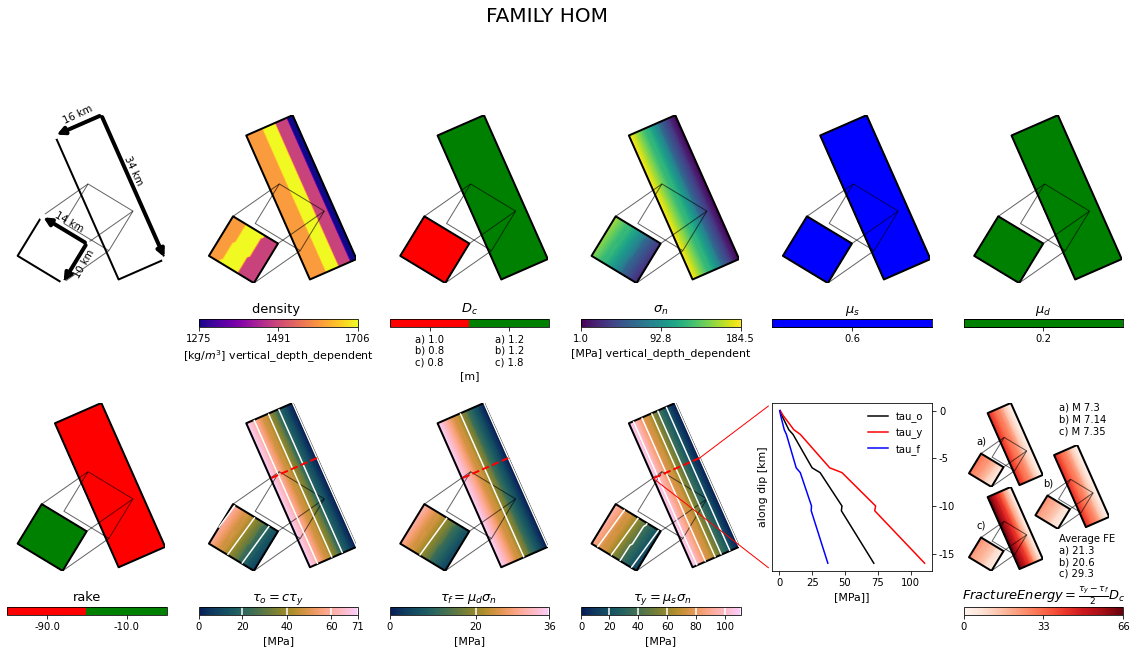

In [20]:
# plot FAMILY HOM 
# ------------------

# plot parameters
# -------------------
fig = plt.figure(figsize=(20, 15))
plt.tight_layout()

icol = 6
irow = 3
l=ind_ipo[0]

i = 1
ax = fig.add_subplot(irow, icol, i)
v_a = None  # slip_a
v_b = None  # slip_b
vmin = 0  # min(v_a.min(),v_b.min())
vmax = 0  # max(v_a.max(),v_b.max())
txt = ''
colors = ['white']
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap=plt.cm.colors.ListedColormap(colors), colors=colors,dimension=True)

i = 2
ax = fig.add_subplot(irow, icol, i)
v_a = rho_a
v_b = rho_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = 'density [kg/$m^3$] '+DENSITY_METHOD
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax,
                         txt, cmap='plasma', fmat="%.0f")

i = 3
ax = fig.add_subplot(irow, icol, i)
v_a = D_CR_a
v_b = D_CR_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$D_c$ [m]'
colors = ['red', 'green']
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap=plt.cm.colors.ListedColormap(colors), colors=colors,
                        labelbar=['a) 1.0\nb) 0.8\nc) 0.8','a) 1.2\nb) 1.2\nc) 1.8'])

i = 4
ax = fig.add_subplot(irow, icol, i)
v_a = NORMAL_STRESS_a
v_b = NORMAL_STRESS_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\sigma_n$ [MPa] '+NORMAL_STRESS_METHOD
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='viridis')


i = 5
ax = fig.add_subplot(irow, icol, i)
v_a = mu_s_a
v_b = mu_s_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\mu_s$'
colors = ['blue']
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap=plt.cm.colors.ListedColormap(colors), colors=colors)

i = 6
ax = fig.add_subplot(irow, icol, i)
v_a = mu_d_a
v_b = mu_d_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\mu_d$'
colors = ['green']
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap=plt.cm.colors.ListedColormap(colors), colors=colors)

i = 7
ax = fig.add_subplot(irow, icol, i)
v_a = -90+0*tmp_a
v_b = -10+0*tmp_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = 'rake'
colors = ['red', 'green']
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap=plt.cm.colors.ListedColormap(colors), colors=colors)

i = 8
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_0_a
v_b = TAU_0_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\\tau_{o} = c \\tau_{y}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cm.batlow,profile=True,levels=20,fmat='%i')

i = 9
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_F_a
v_b = TAU_F_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\\tau_f = \\mu_{d} \\sigma_{n}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cm.batlow,profile=True,levels=20,fmat='%i')

i = 12
ax = fig.add_subplot(irow, icol, i)
import matplotlib.gridspec as gridspec
inner = gridspec.GridSpecFromSubplotSpec(4, 12,
                    subplot_spec=ax, wspace=0., hspace=0.)
cmapf='Reds'
vmin = 0
vmax = 66
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
clb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapf),
                       ticks=[0,33,66],
                        spacing='proportional', orientation='horizontal')
clb.ax.set_title('$Fracture Energy = \\frac{\\tau_{y} - \\tau_{f} }{2}D_{c}$')
ax.set_axis_off()
ax.text(0.6, 1, 'a) M 7.3\nb) M 7.14\nc) M 7.35', transform=ax.transAxes,
      fontsize=10, fontweight='normal', va='top',ha='left')

ax1 = plt.Subplot(fig, inner[0:2,0:6])

v_a = .5*1.2*(TAU_Y_a-TAU_F_a)
v_b = .5*1*(TAU_Y_b-TAU_F_b)
femeana=np.concatenate([v_a.ravel(), v_b.ravel()]).mean()
d = plot_topview_2faults(ax1, v_a, v_b, vmin, vmax, txt,cmap=cmapf,colbar=False)
ax1.text(0.15, 0.6, 'a)', transform=ax1.transAxes,
      fontsize=10, fontweight='normal', va='top')
fig.add_subplot(ax1)

ax1 = plt.Subplot(fig, inner[1:3,5:11])

v_a = .5*1.2*(TAU_Y_a-TAU_F_a)
v_b = .5*0.8*(TAU_Y_b-TAU_F_b)
femeanb=np.concatenate([v_a.ravel(), v_b.ravel()]).mean()
d = plot_topview_2faults(ax1, v_a, v_b, vmin, vmax, txt,cmap=cmapf,colbar=False)
ax1.text(0.15, 0.6, 'b)', transform=ax1.transAxes,
      fontsize=10, fontweight='normal', va='top')
fig.add_subplot(ax1)

ax1 = plt.Subplot(fig, inner[2:4,0:6])

v_a = .5*1.8*(TAU_Y_a-TAU_F_a)
v_b = .5*0.8*(TAU_Y_b-TAU_F_b)
femeanc=np.concatenate([v_a.ravel(), v_b.ravel()]).mean()
d = plot_topview_2faults(ax1, v_a, v_b, vmin, vmax, txt,cmap=cmapf,colbar=False)
ax1.text(0.15, 0.6, 'c)', transform=ax1.transAxes,
      fontsize=10, fontweight='normal', va='top')
fig.add_subplot(ax1)

ax.text(0.6, .22, 'Average FE\na) '+str(round(femeana,1))+ '\nb) '+str(round(femeanb,1))+ '\nc) '+str(round(femeanc,1)),
        transform=ax.transAxes,
      fontsize=10, fontweight='normal', va='top',ha='left')


i = 10
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_Y_a
v_b = TAU_Y_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = ' $\\tau_y = \\mu_{s} \\sigma_{n}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cm.batlow,profile=True,levels=20,fmat='%i')

i = 11
ax1 = fig.add_subplot(irow, icol, i)
ax1.plot(TAU_0_a[l,:],zv_a[l,:],label='tau_o',color='k')
ax1.plot(TAU_Y_a[l,:],zv_a[l,:],label='tau_y',color='r')
ax1.plot(TAU_F_a[l,:],zv_a[l,:],label='tau_f',color='b')
ax1.legend(frameon=False)
ax1.yaxis.tick_right()
ax1.set_yticks([0,-5000,-10000,-15000])
ax1.set_yticklabels(str(_) for _ in [0,-5,-10,-15])
ax1.set_ylabel('along dip [km]')
ax1.set_xlabel('[MPa]]')
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
clb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.colors.ListedColormap(['white'])), ticks=[],
                           spacing='proportional', format='%.1f', orientation='horizontal')
clb.outline.set_visible(False)
from matplotlib.patches import ConnectionPatch
xy=(utmx_a[l,0],utmy_a[l,0])
xy1=(0,1)
con = ConnectionPatch(
    xyA=xy, coordsA=ax.transData,
    xyB=xy1, coordsB=ax1.transAxes,
    arrowstyle="-", shrinkB=5,color='r')
ax1.add_artist(con)
xy=(utmx_a[l,-1],utmy_a[l,-1])
xy1=(0,0)
con = ConnectionPatch(
    xyA=xy, coordsA=ax.transData,
    xyB=xy1, coordsB=ax1.transAxes,
    arrowstyle="-", shrinkB=5,color='r')
ax1.add_artist(con)

plt.suptitle('FAMILY HOM')
plt.show()

### FAMILY B

Family (B) has heterogeneous distributions of initial shear stress and yield strength. The latter is parameterized as a heterogeneous distribution of  $\mu_{s}$ in the range of [0.2, 0.7] while $\mu_{d}$ is kept constant at 0.2. 

In [23]:
# common parameters
# ------------------------

# Dc, slip weaking critical distance
# ----------------------------------------
# 𝐷𝑐  is a percentage of the total slip, the percentage depends on the depth
dc_nncia=[0.3,0.3,0.1,0.1] 
D_CR_tres=0.02
D_CR_b=tmp_b.copy() 
D_CR_a=tmp_a.copy() 

for zdc,dc_val in zip(z_nncia[len(dc_nncia)-1::-1],dc_nncia[::-1]):
    #print(zdc,dc_val)
    cdc = depth_z_a >= zdc
    D_CR_a[cdc] = dc_val
    cdc = depth_z_b >= zdc
    D_CR_b[cdc] = dc_val
    
D_CR_a=D_CR_a*slip_a
cdc = D_CR_a <= D_CR_tres
D_CR_a[cdc]=D_CR_tres 

D_CR_b=D_CR_b*slip_b
cdc = D_CR_b <= D_CR_tres
D_CR_b[cdc]=D_CR_tres

# density
# --------
DENSITY_METHOD = 'vertical_depth_dependent'
rho_b = rho_val*tmp_b
rho_a = rho_val*tmp_a

for zrho, rho_val in zip(z_nncia[::-1], rho_nncia[::-1]):
    # print(zrho,rho_val,zrho/np.sin(dip*np.pi/180))
    criterium = depth_z_a >= zrho
    rho_a[criterium] = rho_val
    criterium = depth_z_b >= zrho
    rho_b[criterium] = rho_val

rho_a = rho_a-1000  # adding the presence of fluid
rho_b = rho_b-1000  # adding the presence of fluid

# normal stress (𝜎𝑛)
# ---------------------
NORMAL_STRESS_METHOD='vertical_depth_dependent'

# zv is negative but NORMAL_STRESS is positive in compression
NORMAL_STRESS_a = -rho_a*gravity*depth_z_a/1e6 # [MPa]
NORMAL_STRESS_uni_a = -rho_val*gravity*depth_z_a/1e6 # [MPa]

# zv is negative but NORMAL_STRESS is positive in compression
NORMAL_STRESS_b = -rho_b*gravity*depth_z_b/1e6 # [MPa]
NORMAL_STRESS_uni_b = -rho_val*gravity*depth_z_b/1e6 # [MPa]

sn_thre = 1  # [MPa]
NORMAL_STRESS_a[NORMAL_STRESS_a < sn_thre] = sn_thre
NORMAL_STRESS_b[NORMAL_STRESS_b < sn_thre] = sn_thre

In [28]:
# family B parameters
# -------------------------
NOME_SIMULAZIONE='Family B'

# dynamic friction (𝜇𝑑), static friction (𝜇𝑠)
# -------------------------------------------------
MU_D = 0.2  # dynamic friction
MU_S = 0.5  # static friction
MU_TR = 10.  # maximum static friction

# initial stress (𝜏𝑜) , dynamic frictional stress (𝜏𝑓=𝜇𝑑𝜎𝑛), yield stress (𝜏𝑦)
# --------------------------------------------------------------------------------------
SLIP_2_STRESS_FACTOR_a=4
SLIP_2_STRESS_FACTOR_b=5
TAU_F_a = NORMAL_STRESS_a*MU_D
TAU_F_b = NORMAL_STRESS_b*MU_D

# 𝜏𝑜  is set 𝜏𝑜=𝜏𝑓+𝑐𝑠𝑙𝑖𝑝 → 𝑠𝑡𝑟𝑒𝑠𝑠∗𝑠𝑙𝑖𝑝
# ---------------------------------------------
TAU_0_a=TAU_F_a+slip_a*SLIP_2_STRESS_FACTOR_a
TAU_0_b=TAU_F_b+slip_b*SLIP_2_STRESS_FACTOR_b

# Strengh excess  Δ𝑆  is defined as a function of the distance from the hypocenter  
# -----------------------------------------------------------------------------------------------
# Δ𝑆 = ((𝜏𝑚𝑎𝑥𝑦−𝜏𝑚𝑖𝑛𝑦)/𝑟𝑐) ∗ 𝑟 + 𝜏𝑚𝑖𝑛𝑦  with  𝜏𝑚𝑖𝑛𝑦 = 0.1  and 𝜏𝑚𝑎𝑥𝑦 = 6
def strengh_excess(xx, yy, xxc, yyc, rr_crit=8000, tauy_min=0.1, tauy_max=6):
    ffy=np.ones(xx.shape)*tauy_max
    r=np.sqrt((xx-xxc)**2+(yy-yyc)**2)
    c=r <= rr_crit
    ffy[c]=(tauy_max-tauy_min)/rr_crit*r[c]+tauy_min
    return ffy

STREXCE_a=strengh_excess(xv_a,zv_a,xv_a[ind_ipo],zv_a[ind_ipo])
STREXCE_b=strengh_excess(xv_b,zv_b,xv_b[ind_ipo_b],zv_b[ind_ipo_b])

# 𝜏𝑦  is set 𝜏𝑦=𝜏𝑜+Δ𝑆
# -------------------------
TAU_Y_a=TAU_0_a+STREXCE_a
TAU_Y_b=TAU_0_b+STREXCE_b

mu_s_a = TAU_Y_a/NORMAL_STRESS_a
mu_s_a = np.minimum(mu_s_a, MU_TR)
TAU_Y_a = mu_s_a*NORMAL_STRESS_a

mu_s_b = TAU_Y_b/NORMAL_STRESS_b
mu_s_b = np.minimum(mu_s_b, MU_TR)
TAU_Y_b = mu_s_b*NORMAL_STRESS_b

mu_d_a = TAU_F_a/NORMAL_STRESS_a
mu_d_b = TAU_F_b/NORMAL_STRESS_b

stress_a=TAU_0_a
stress_b=TAU_0_b

R_a=np.round((stress_a-TAU_F_a)/(TAU_Y_a-TAU_F_a),1)
R_b=np.round((stress_b-TAU_F_b)/(TAU_Y_b-TAU_F_b),1)

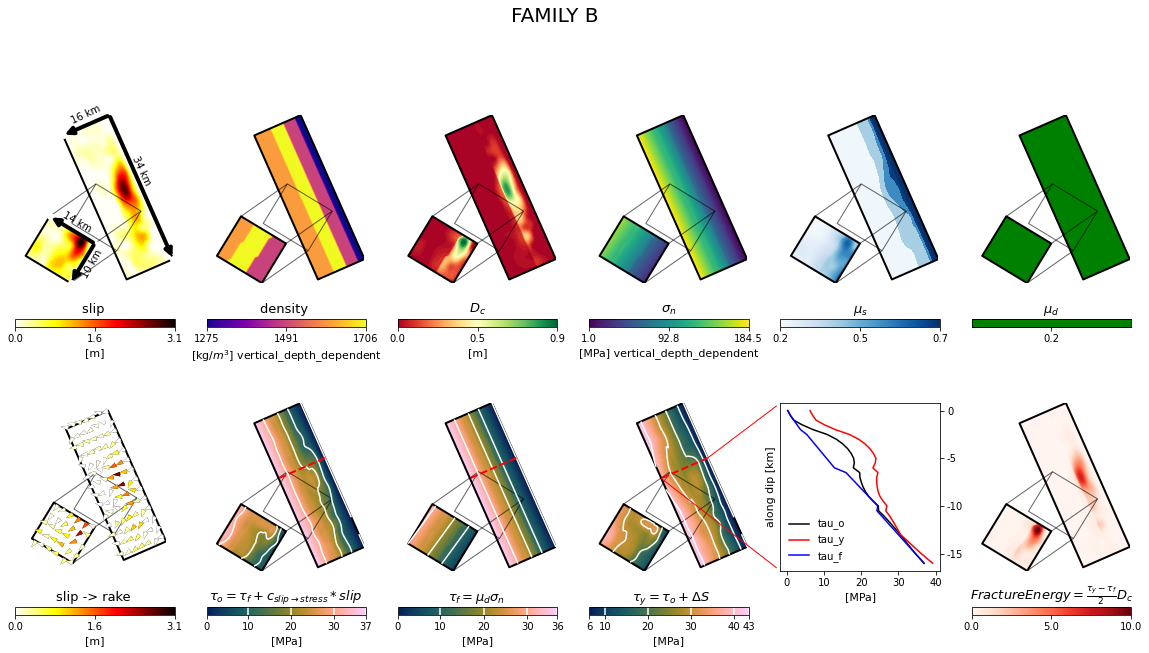

In [29]:
# plot FAMILY B 
# ------------------
fig = plt.figure(figsize=(20, 15))
plt.tight_layout()

icol = 6
irow = 3
l=ind_ipo[0]

i = 1
ax = fig.add_subplot(irow, icol, i)
v_a = slip_a
v_b = slip_b
vmin = min(v_a.min(),v_b.min())
vmax = max(v_a.max(),v_b.max())
txt = 'slip [m]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='hot_r',dimension=True)

i = 2
ax = fig.add_subplot(irow, icol, i)
v_a = rho_a
v_b = rho_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = 'density [kg/$m^3$] '+DENSITY_METHOD
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax,
                         txt, cmap='plasma', fmat="%.0f")

i = 3
ax = fig.add_subplot(irow, icol, i)
v_a = D_CR_a
v_b = D_CR_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$D_c$ [m]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='RdYlGn')

i = 4
ax = fig.add_subplot(irow, icol, i)
v_a = NORMAL_STRESS_a
v_b = NORMAL_STRESS_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\sigma_n$ [MPa] '+NORMAL_STRESS_METHOD
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='viridis')

i = 5
ax = fig.add_subplot(irow, icol, i)
v_a = mu_s_a
v_b = mu_s_b
vmin = min(v_a.min(), v_b.min())
vmax = .7# max(v_a.max(), v_b.max())
txt = '$\mu_s$'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                        cmap='Blues')

i = 6
ax = fig.add_subplot(irow, icol, i)
v_a = mu_d_a
v_b = mu_d_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\mu_d$'
colors = ['green']
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap=plt.cm.colors.ListedColormap(colors), colors=colors)

cmapt=cm.batlow

i = 7
ax = fig.add_subplot(irow, icol, i)
v_a = slip_a
v_b = slip_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = 'slip -> rake [m]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='hot_r',quiver=True)

i = 8
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_0_a
v_b = TAU_0_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\\tau_{o} = \\tau_{f} + c_{slip \\rightarrow stress}*slip$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmapt,profile=True,levels=10,fmat='%i')

i = 9
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_F_a
v_b = TAU_F_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\\tau_f = \\mu_{d} \\sigma_{n}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmapt,profile=True,levels=10,fmat='%i')

i = 12
ax = fig.add_subplot(irow, icol, i)
v_a = .5*D_CR_a*(TAU_Y_a-TAU_F_a)
v_b = .5*D_CR_b*(TAU_Y_b-TAU_F_b)
vmin = min(v_a.min(), v_b.min())
vmax = 10 #max(v_a.max(), v_b.max())
txt = '$Fracture Energy = \\frac{\\tau_{y} - \\tau_{f} }{2}D_{c}$'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='Reds')

i = 10
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_Y_a
v_b = TAU_Y_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = ' $\\tau_y = \\tau_o + \\Delta S$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmapt,profile=True,levels=10,fmat='%i')

i = 11
ax1 = fig.add_subplot(irow, icol, i)
ax1.plot(TAU_0_a[l,:],zv_a[l,:],label='tau_o',color='k')
ax1.plot(TAU_Y_a[l,:],zv_a[l,:],label='tau_y',color='r')
ax1.plot(TAU_F_a[l,:],zv_a[l,:],label='tau_f',color='b')
ax1.legend(frameon=False)
ax1.yaxis.tick_right()
ax1.set_yticks([0,-5000,-10000,-15000])
ax1.set_yticklabels(str(_) for _ in [0,-5,-10,-15])
ax1.set_ylabel('along dip [km]')
ax1.set_xlabel('[MPa]')
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
clb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.colors.ListedColormap(['white'])), ticks=[],
                           spacing='proportional', format='%.1f', orientation='horizontal')
clb.outline.set_visible(False)
from matplotlib.patches import ConnectionPatch
xy=(utmx_a[l,0],utmy_a[l,0])
xy1=(0,1)
con = ConnectionPatch(
    xyA=xy, coordsA=ax.transData,
    xyB=xy1, coordsB=ax1.transAxes,
    arrowstyle="-", shrinkB=5,color='r')
ax1.add_artist(con)
xy=(utmx_a[l,-1],utmy_a[l,-1])
xy1=(0,0)
con = ConnectionPatch(
    xyA=xy, coordsA=ax.transData,
    xyB=xy1, coordsB=ax1.transAxes,
    arrowstyle="-", shrinkB=5,color='r')
ax1.add_artist(con)

plt.suptitle('FAMILY B')
plt.show()

### FAMILY C

Family C has heterogeneous distribution of dynamic friction $\mu_{d}$ with values between 0.1 and 0.45 and constant $\mu_{s}=$0.5.

In [34]:
# family C parameters
# -------------------------
NOME_SIMULAZIONE='Family C'

# Dc, slip weaking critical distance
# ----------------------------------------
# 𝐷𝑐  is a percentage of the total slip, the percentage depends on the depth

dc_nncia=[0.3,0.3,0.1,0.1] 
D_CR_tres=0.06
D_CR_b=tmp_b.copy() 
D_CR_a=tmp_a.copy() 

for zdc,dc_val in zip(z_nncia[len(dc_nncia)-1::-1],dc_nncia[::-1]):
    #print(zdc,dc_val)
    cdc = depth_z_a >= zdc
    D_CR_a[cdc] = dc_val
    cdc = depth_z_b >= zdc
    D_CR_b[cdc] = dc_val
    
D_CR_a=D_CR_a*slip_a
cdc = D_CR_a <= D_CR_tres
D_CR_a[cdc]=D_CR_tres 

D_CR_b=D_CR_b*slip_b
cdc = D_CR_b <= D_CR_tres
D_CR_b[cdc]=D_CR_tres

# dynamic friction (𝜇𝑑), static friction (𝜇𝑠)
# -------------------------------------------------
MU_D = 0.1  # dynamic friction
MU_S = 0.5  # static friction
MU_TR = 10.  # maximum static friction

# 𝜏𝑦  is set 𝜏𝑦=𝜇𝑠𝜎𝑛
TAU_Y_a=NORMAL_STRESS_a*MU_S
TAU_Y_b=NORMAL_STRESS_b*MU_S

mu_s_a = TAU_Y_a/NORMAL_STRESS_a
mu_s_b = TAU_Y_b/NORMAL_STRESS_b

# 𝜏𝑜  is set 𝜏𝑜=𝑐𝜇𝑠𝜎𝑛 where 𝑐=0.96
TAU_0_a=TAU_Y_a*.96
TAU_0_b=TAU_Y_b*.96

# 𝜏𝑓  is set 𝜏𝑓=𝜏𝑜−𝑐𝑠𝑙𝑖𝑝 → 𝑠𝑡𝑟𝑒𝑠𝑠 ∗ 𝑠𝑙𝑖𝑝
SLIP_2_STRESS_FACTOR_a=5.5
SLIP_2_STRESS_FACTOR_b=6.5
slip_a_thres=slip_a.copy()
slip_b_thres=slip_b.copy()

Slip_thres=0.4
slip_a_thres[slip_a_thres <= Slip_thres]=Slip_thres
slip_b_thres[slip_b_thres <= Slip_thres]=Slip_thres

TAU_F_a=TAU_0_a-slip_a_thres*SLIP_2_STRESS_FACTOR_a
TAU_F_b=TAU_0_b-slip_b_thres*SLIP_2_STRESS_FACTOR_b

mu_d_a=TAU_F_a/NORMAL_STRESS_a
mu_d_b=TAU_F_b/NORMAL_STRESS_b

tmu = mu_d_a <= MU_D
mu_d_a[tmu]= MU_D

tmu = mu_d_b <= MU_D
mu_d_b[tmu]= MU_D

TAU_F_a=NORMAL_STRESS_a*mu_d_a
TAU_F_b=NORMAL_STRESS_b*mu_d_b

mu_d_a = TAU_F_a/NORMAL_STRESS_a
mu_d_b = TAU_F_b/NORMAL_STRESS_b

stress_a=TAU_0_a
stress_b=TAU_0_b

R_a=np.round((stress_a-TAU_F_a)/(TAU_Y_a-TAU_F_a),1)
R_b=np.round((stress_b-TAU_F_b)/(TAU_Y_b-TAU_F_b),1)

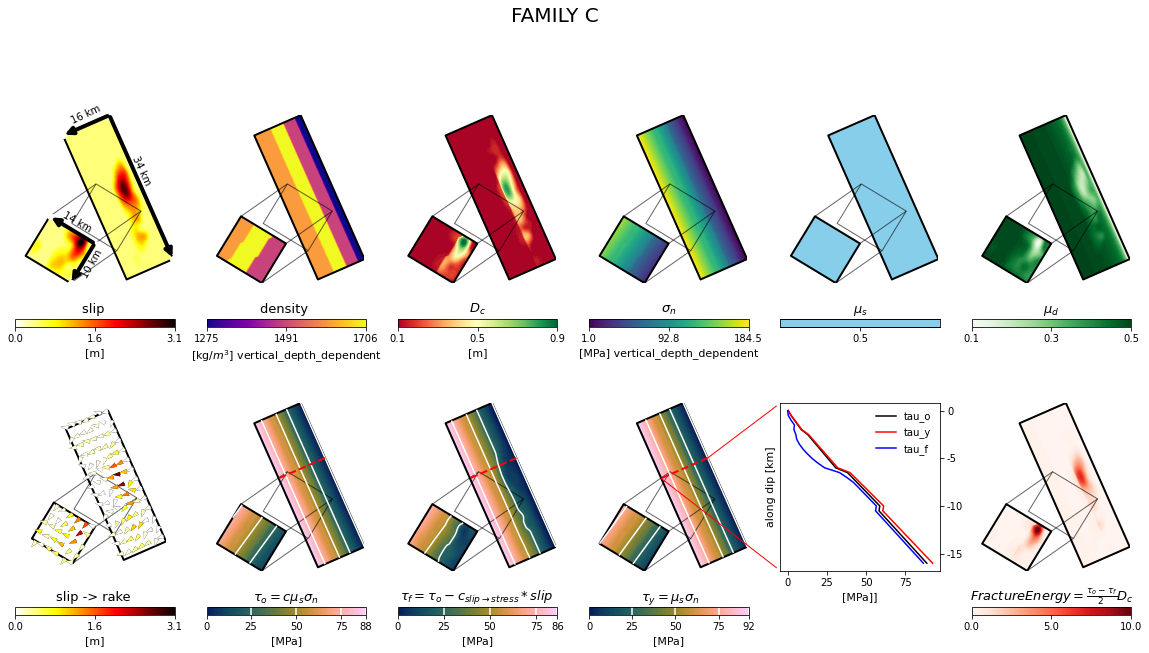

In [39]:
# plot FAMILY C 
# ------------------
fig = plt.figure(figsize=(20, 15))
plt.tight_layout()

icol = 6
irow = 3
l=ind_ipo[0]

i = 1
ax = fig.add_subplot(irow, icol, i)
v_a = slip_a_thres
v_b = slip_b_thres
vmin = 0#min(v_a.min(),v_b.min())
vmax = max(v_a.max(),v_b.max())
txt = 'slip [m]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='hot_r',dimension=True)

i = 2
ax = fig.add_subplot(irow, icol, i)
v_a = rho_a
v_b = rho_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = 'density [kg/$m^3$] '+DENSITY_METHOD
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax,
                         txt, cmap='plasma', fmat="%.0f")

i = 3
ax = fig.add_subplot(irow, icol, i)
v_a = D_CR_a
v_b = D_CR_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$D_c$ [m]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='RdYlGn')

i = 4
ax = fig.add_subplot(irow, icol, i)
v_a = NORMAL_STRESS_a
v_b = NORMAL_STRESS_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\sigma_n$ [MPa] '+NORMAL_STRESS_METHOD
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='viridis')

i = 5
ax = fig.add_subplot(irow, icol, i)
v_a = mu_s_a
v_b = mu_s_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\mu_s$'
colors = ['skyblue']
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap=plt.cm.colors.ListedColormap(colors), colors=colors)

i = 6
ax = fig.add_subplot(irow, icol, i)
v_a = mu_d_a
v_b = mu_d_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\mu_d$'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='Greens')

cmapt=cm.batlow

i = 7
ax = fig.add_subplot(irow, icol, i)
v_a = slip_a
v_b = slip_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = 'slip -> rake [m]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap='hot_r',quiver=True)

lev=25
i = 8
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_0_a
v_b = TAU_0_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\\tau_{o} = c \\mu_s \\sigma_n$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmapt,profile=True,levels=lev,fmat='%i')

i = 9
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_F_a
v_b = TAU_F_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = '$\\tau_{f} = \\tau_{o} - c_{slip \\rightarrow stress}*slip$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmapt,profile=True,levels=lev,fmat='%i')

i = 12
ax = fig.add_subplot(irow, icol, i)
v_a = .5*D_CR_a*(TAU_Y_a-TAU_F_a)
v_b = .5*D_CR_b*(TAU_Y_b-TAU_F_b)
vmin = min(v_a.min(), v_b.min())
vmax = 10#max(v_a.max(), v_b.max())
txt = '$Fracture Energy = \\frac{\\tau_{o} - \\tau_{f} }{2}D_{c}$'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt,
                         cmap='Reds')

i = 10
ax = fig.add_subplot(irow, icol, i)
v_a = TAU_Y_a
v_b = TAU_Y_b
vmin = min(v_a.min(), v_b.min())
vmax = max(v_a.max(), v_b.max())
txt = ' $\\tau_y = \\mu_{s} \\sigma_{n}$ [MPa]'
d = plot_topview_2faults(ax, v_a, v_b, vmin, vmax, txt, cmap=cmapt,profile=True,levels=lev,fmat='%i')

i = 11
ax1 = fig.add_subplot(irow, icol, i)
ax1.plot(TAU_0_a[l,:],zv_a[l,:],label='tau_o',color='k')
ax1.plot(TAU_Y_a[l,:],zv_a[l,:],label='tau_y',color='r')
ax1.plot(TAU_F_a[l,:],zv_a[l,:],label='tau_f',color='b')
ax1.legend(frameon=False)
ax1.yaxis.tick_right()
ax1.set_yticks([0,-5000,-10000,-15000])
ax1.set_yticklabels(str(_) for _ in [0,-5,-10,-15])
ax1.set_ylabel('along dip [km]')
ax1.set_xlabel('[MPa]]')
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
clb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.colors.ListedColormap(['white'])), ticks=[],
                           spacing='proportional', format='%.1f', orientation='horizontal')
clb.outline.set_visible(False)

from matplotlib.patches import ConnectionPatch
xy=(utmx_a[l,0],utmy_a[l,0])
xy1=(0,1)
con = ConnectionPatch(
    xyA=xy, coordsA=ax.transData,
    xyB=xy1, coordsB=ax1.transAxes,
    arrowstyle="-", shrinkB=5,color='r')
ax1.add_artist(con)
xy=(utmx_a[l,-1],utmy_a[l,-1])
xy1=(0,0)
con = ConnectionPatch(
    xyA=xy, coordsA=ax.transData,
    xyB=xy1, coordsB=ax1.transAxes,
    arrowstyle="-", shrinkB=5,color='r')
ax1.add_artist(con)

plt.suptitle('FAMILY C')
plt.show()